# Human Centered DS - Models

## Set up

### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)
#Bulk imported all models for now

### Helper Functions

In [ ]:
def noOutliers(d, feature):
    Q1 = d[feature].quantile(0.25)
    Q3 = d[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out rows with values outside the bounds
    return d[(d[feature] >= lower_bound) & (d[feature] <= upper_bound)]

In [ ]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    # lesser values are better (a<b ... a better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)
rms_scorer = metrics.make_scorer(rms_error)

In [ ]:
def check_binary_variable(column):
    unique_values = column.unique()
    return len(unique_values) == 2 and all(value in [0, 1] for value in unique_values)

def binary_variables(df):
    binary_vars = []
    for column in df.columns:
        if check_binary_variable(df[column]):
            binary_vars.append(column)
    df[binary_vars] = df[binary_vars].astype(bool)
    return df

def convert_to_boolean(df):
    binary_cols = df.select_dtypes(include='int').columns
    df[binary_cols] = df[binary_cols].astype(bool)
    return df

### Data

In [ ]:
# Step 0.1: Access Google Drive.

# import requisite library
from google.colab import drive

# login and verity that you want to use it
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 0.2: Move us to the "Data" folder

# identify the root directory
root_dir = "/content/drive/My Drive/"

# identify the location of the cleaned data folder
data_folder = root_dir + "Data - Human Centered DS/Cleaned Data/"

# change directory to the data folder
os.chdir(data_folder)

In [ ]:
# Step 0.3: Import our cleaned CSVs

# Set up some dictionaries to store our data
Q1_dic = {'folder':'Question_1'}
Q2_dic = {'folder':'Question_2'}
Q3_dic = {'folder':'Question_3'}
Q4_dic = {'folder':'Question_4'}
all_Q_dic = [Q1_dic, Q2_dic, Q3_dic, Q4_dic]

# iterate through cleaned data subfolders
for Q in all_Q_dic:
  sub_folder = data_folder + Q['folder']
  # print(sub_folder)

  # now iterate through the files in the folder
  for root, direc, files in os.walk(sub_folder):
    for file in files:
      # get our file location
      file_path = os.path.join(root, file)

      # split the file into its name and extension
      filename, extension = os.path.splitext(file)

      # read our file to df and store in the current dic
      Q[filename] = pd.read_csv(file_path)

      # print the key for future reference
      print(Q['folder'],filename)

Question_1 Police_full
Question_1 Police_Stations
Question_1 Random
Question_2 Random
Question_2 Citizen_Admin
Question_3 Random_Heterogeninty
Question_3 User_Survery
Question_3 Citizen
Question_4 Admin
Question_4 CCTVwFemaleStaff
Question_4 Random


In [ ]:
#Set scaler
scaler = skpre.MinMaxScaler()

## Analysis

### Question 1
**Main Question:**
* What is the relationship between the number of female staff and officers at a given station with the perceptions pertaining to crimes against women held by all staff and officers at that station?

**Subquestions:**
* Is this relationship different if we measure the perceptions of female staff/officers and male staff/officers separately?
* Are these relationships different between the baseline and endline surveys?

#### Data

In [ ]:
for key, value in Q1_dic.items():
  print(key)
  try:
    display(value.head())
    value.info()
  except:
    display(value)

folder


'Question_1'

Police_full


,uid,gender,e_wcase,e_effective,e_false_case,e_helpful,e_add_officer,e_add_female,e_female_better,e_taken_seriously,...,b_pol_impt_base,b_thana_impt_base,b_wcase_base,b_effective_base,b_helpful_base,b_add_officer_base,b_add_female_base,b_female_better_base,b_sensitivity_base,attrit
0,2141733,male,too much attention,very effective,uncommon,very helpful,much more effective,Less effective,female,strongly agree,...,0.0,0.0,enough attention,very effective,helpful,more effective,much less effective,female,8.0,0.0
1,2141734,male,too much attention,effective,very uncommon,helpful,much more effective,Less effective,female,agree,...,0.0,0.0,too much attention,very effective,very helpful,much more effective,much less effective,female,8.0,0.0
2,2141739,male,too much attention,very effective,very uncommon,very helpful,more effective,Less effective,female,agree,...,0.0,0.0,enough attention,effective,helpful,more effective,much less effective,male,5.0,0.0
3,2141742,male,too much attention,very effective,uncommon,helpful,much more effective,No difference,no difference,agree,...,0.0,0.0,too much attention,very effective,helpful,more effective,much less effective,male,8.0,0.0
4,2141740,male,enough attention,effective,uncommon,very helpful,much more effective,Less effective,female,strongly agree,...,0.0,0.0,too much attention,very effective,helpful,much more effective,less effective,female,6.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 79 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     1009 non-null   int64  
 1   gender                  1009 non-null   object 
 2   e_wcase                 1009 non-null   object 
 3   e_effective             1009 non-null   object 
 4   e_false_case            1009 non-null   object 
 5   e_helpful               1009 non-null   object 
 6   e_add_officer           1009 non-null   object 
 7   e_add_female            1009 non-null   object 
 8   e_female_better         1009 non-null   object 
 9   e_taken_seriously       1009 non-null   object 
 10  e_prof_dev              1009 non-null   object 
 11  e_work_help             1009 non-null   object 
 12  e_pol_impt              1009 non-null   float64
 13  e_thana_impt            1009 non-null   float64
 14  e_sensitivity           1009 non-null   

,uid,gender,e_wcase,e_effective,e_false_case,e_helpful,e_add_officer,e_add_female,e_female_better,e_taken_seriously,...,b_total_sampled,b_female_sampled,b_male_sampled,b_total_surveyed,b_female_surveyed,b_male_surveyed,e_male_weight,b_male_weight,e_female_weight,b_female_weight
0,2240137,male,too much attention,very effective,common,very helpful,more effective,Less effective,female,disagree,...,12,1,11,10,0,10,3.818182,3.272727,6.0,3.0
1,2240133,male,too much attention,very effective,common,very helpful,much more effective,No difference,female,strongly agree,...,12,1,11,10,0,10,3.818182,3.272727,6.0,3.0
2,2240136,male,too much attention,very effective,uncommon,very helpful,much more effective,Less effective,female,disagree,...,12,1,11,10,0,10,3.818182,3.272727,6.0,3.0
3,2240132,female,too much attention,very effective,common,helpful,much more effective,Less effective,female,agree,...,12,1,11,10,0,10,3.818182,3.272727,6.0,3.0
4,2240134,male,too much attention,very effective,very common,very helpful,much more effective,No difference,female,agree,...,12,1,11,10,0,10,3.818182,3.272727,6.0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     1904 non-null   int64  
 1   gender                  1904 non-null   object 
 2   e_wcase                 1904 non-null   object 
 3   e_effective             1904 non-null   object 
 4   e_false_case            1904 non-null   object 
 5   e_helpful               1904 non-null   object 
 6   e_add_officer           1904 non-null   object 
 7   e_add_female            1904 non-null   object 
 8   e_female_better         1904 non-null   object 
 9   e_taken_seriously       1904 non-null   object 
 10  e_prof_dev              1904 non-null   object 
 11  e_work_help             1904 non-null   object 
 12  e_pol_impt              1904 non-null   float64
 13  e_thana_impt            1904 non-null   float64
 14  e_sensitivity           1904 non-null   

,rand_index,total_assigned_officers,total_fir_2017,population,urban,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd
0,0,47,412,129345,Rural,1,-0.234041,Treatment,women officers,1000,9.000000,2.916667,2.200000,0,1
1,1,29,218,170000,Rural,1,-0.960574,Control,control,1000,7.462185,1.545454,1.798067,0,0
2,2,75,694,102467,Rural,1,1.042663,Control,control,1000,7.462185,1.090909,1.798067,0,0
3,3,40,144,54000,Rural,1,-1.590761,Treatment,regular mhd,1000,7.000000,3.897297,2.030000,1,0
4,4,37,130,76376,Rural,1,-1.570695,Treatment,women officers,1000,9.000000,4.157658,2.200000,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rand_index               180 non-null    int64  
 1   total_assigned_officers  180 non-null    int64  
 2   total_fir_2017           180 non-null    int64  
 3   population               180 non-null    int64  
 4   urban                    180 non-null    object 
 5   dist_urban               180 non-null    int64  
 6   strat_pca                180 non-null    float64
 7   treatment                180 non-null    object 
 8   group                    180 non-null    object 
 9   dist_id                  180 non-null    int64  
 10  implement_quality        180 non-null    float64
 11  training_score           180 non-null    float64
 12  comm_outreach_strength   180 non-null    float64
 13  regular_whd              180 non-null    int64  
 14  women_whd                1

#### Police Survey Linear Regression
I am going to use a linear regression to see whether there is a relationship between the percent of women officers at a station and the responses to the police survey on effectiveness of police regarding crimes against women. One hypothesis is that a higher number of women at a station might improve perceptions of the importance of women's issues, or the effectiveness of women officers. Hopefully a linear regression can help show if such a relationship exists.

I will look exclusively at baseline data for now, to avoid confounding factors that might be introduced by treatment.

In [ ]:
# extract our columns to analyze from Police_Stations
polstat = Q1_dic['Police_Stations']

# drop any duplicated data points
polstat = polstat.drop_duplicates()

X = polstat[['gender',
             'urban',
             'population',
             'implement_quality',
             'training_score',
             'comm_outreach_strength',
             'b_wcase',
             'b_effective',
             'b_pol_impt',
             'b_thana_impt',
             'b_sensitivity',
             'b_helpful',
             'b_female_better',
             'b_add_officer',
             'b_add_female']]

# convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# our predicted value is the fraction of women to all staff at a given station
# we'll calculate that from the fields b_female_staff and b_total_staff

Y = polstat.copy()
Y['fraction'] = Y['b_female_staff']/Y['b_total_staff']
y = Y['fraction'] # make a convenient shorthand

In [ ]:
# as a sidebar, let's see what the spread is of female officers across all stations
gens = polstat[['ps_code','b_female_staff','b_total_staff']]
gens['fraction'] = gens['b_female_staff']/gens['b_total_staff']
gens = gens.drop_duplicates()
gens.describe()

<ipython-input-12-38bc2c85b437>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens['fraction'] = gens['b_female_staff']/gens['b_total_staff']


,ps_code,b_female_staff,b_total_staff,fraction
count,180.000000,180.000000,180.000000,180.000000
mean,5857.166667,3.122222,45.472222,0.070280
std,3118.114300,2.051449,21.227533,0.039593
min,1001.000000,0.000000,9.000000,0.000000
25%,3045.750000,2.000000,27.000000,0.043478
50%,5090.500000,3.000000,42.000000,0.065396
75%,8135.250000,4.000000,63.000000,0.094564
max,12180.000000,10.000000,95.000000,0.184211


Let's actually build the model: split train & test, standardize our scores, and train a linear regression!

In [ ]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# initiate a model
model = linear_model.LinearRegression()

# create a pipeline to standardize & fit
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train) #fit_transforms for standardization before fitting model

# predict our outputs
y_preds = pipe.predict(X_test)

Drumroll... and let's look at some measures of accuracy:

In [ ]:
r2 = metrics.r2_score(y_test, y_preds)
rmse = rms_error(y_test, y_preds)

print(f'R-squared = {r2}, RMSE = {rmse}')

R-squared = 0.03118689987871781, RMSE = 0.03797433598376507


Well, that's a pretty abysmal looking R2 score. What does this look like visually? Let's make a scatter plot.

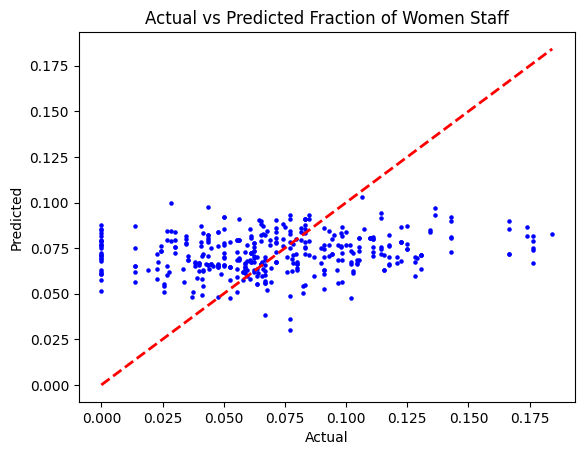

In [ ]:
_ = plt.scatter(y_test, y_preds, color='blue', s=5)
_ = plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
_ = plt.xlabel('Actual')
_ = plt.ylabel('Predicted')
_ = plt.title('Actual vs Predicted Fraction of Women Staff')
plt.show()

Yep, that's no good. It looks like taking all of the survey answers together makes a poor predictor for the number of women officers at a station.

#### Logistic Regression to Identify Gender
From a different direction: can we attempt to identify whether a respondent is male or female based on their responses to the police survey?

In [ ]:
# extract our columns to analyze from Police_Stations, same as before
polstat = Q1_dic['Police_Stations']

# drop any duplicated data points
polstat = polstat.drop_duplicates()

X = polstat[['urban',
             'population',
             'implement_quality',
             'training_score',
             'comm_outreach_strength',
             'b_wcase',
             'b_effective',
             'b_pol_impt',
             'b_thana_impt',
             'b_sensitivity',
             'b_helpful',
             'b_female_better',
             'b_add_officer',
             'b_add_female']]

# convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# we are predicting gender here: 0 for men, 1 for women

Y = polstat.copy()
Y['gender'] = Y['gender'].apply(lambda x: 1 if x in ['female'] else 0)
y = Y['gender']

# check our work
y.value_counts()

,count
gender,
0,1679
1,225


In [ ]:
# make a model!

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# initiate a logistic model
model = linear_model.LogisticRegression(class_weight='balanced')

# feed our data through a scaler -> model pipeline
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train) #fit_transforms for standardization before fitting model
y_preds = pipe.predict(X_test)

In [ ]:
# hold our breath and check accuracy and F1
accuracy = metrics.accuracy_score(y_test, y_preds)
f1 = metrics.f1_score(y_test, y_preds)
print(f'Accuracy = {accuracy}, F1 = {f1}')

Accuracy = 0.6745406824146981, F1 = 0.27906976744186046


Interesting. Okay accuracy, but not a great F1 score. Let's make a confusion matrix to better understand.

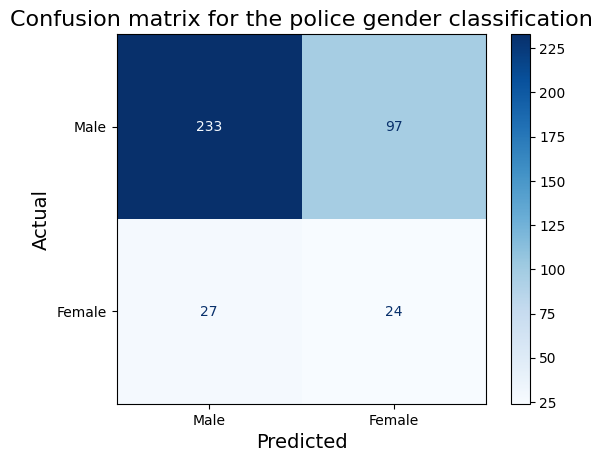

In [ ]:
# call confusion matrix using species test data and the predictions
confusionMatrix = metrics.confusion_matrix(y_test, y_preds)

# bring back the species names
names = ['Male', 'Female']
_ = cmplot = metrics.ConfusionMatrixDisplay(confusionMatrix,
                                    display_labels=names)

# changing the color map to blues
_ = cmplot.plot(cmap=plt.get_cmap('Blues'))

# make some titles
_ = plt.title("Confusion matrix for the police gender classification", fontsize=16)
_ = plt.xlabel("Predicted", fontsize=14)
_ = plt.ylabel("Actual", fontsize=14)

_ = plt.show()

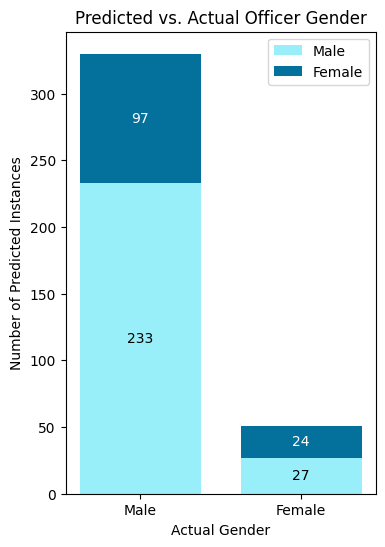

In [ ]:
# let's make an alternative confusion matrix

# arrange our data properly
# print(confusionMatrix)
arm_labs = ['Male','Female']
arm_vals = {
    'Male': [[confusionMatrix[0,0],confusionMatrix[1,0]],"xkcd:robin's egg blue"],
    'Female': [[confusionMatrix[0,1],confusionMatrix[1,1]],'xkcd:ocean blue']
}

# set up our figure
fig, ax = plt.subplots(figsize=(4,6))
bottom = np.zeros(2)
width = 0.75

for lab, arm in arm_vals.items():
    p = ax.bar(arm_labs, arm[0], width, label=lab, bottom=bottom,color=arm[1])
    for i,bar in enumerate(p):
      c = 'black'
      if bar.get_height() in (97, 24):
        c = 'white'
      ax.text(
          bar.get_x() + bar.get_width() / 2, (bar.get_height() / 2) + bottom[i],  # Center text vertically within the bar
          f'{bar.get_height():.0f}', ha='center', va='center', color=c, fontsize=10
      )
    bottom += arm[0]

_ = ax.set_title("Predicted vs. Actual Officer Gender")
_ = ax.set_xlabel("Actual Gender")
_ = ax.set_ylabel("Number of Predicted Instances")
ax.legend(loc="upper right")

# plt.savefig(f'/content/drive/MyDrive/Data - Human Centered DS/Plots/confusion_bars.png', bbox_inches='tight', dpi=400)
plt.show()

Very interesting - the model has an okay chance of correctly identifying men as men, but when it attempts to identify women, we're doing somewhat worse than random chance. The okay accuracy seems better explained by the fact that men are much more common than women, than there being a genuine strong relationship present in the data.

### Question 2
**Main Question:**
* Does the creation of a WHD or a women-run WHD cause an increase in dial100 calls to the station?

**Subquestions:**
* Does the number of calls to the station correlate with community or user satisfaction measures?
* Does this have an effect on the number of reports filed (FIR and DIR)?

#### Data

In [ ]:
for key, value in Q2_dic.items():
  print(key)
  try:
    display(value.head())
    value.info()
  except:
    display(value)

folder


'Question_2'

Random


,rand_index,total_assigned_officers,total_fir_2017,population,urban,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd
0,0,47,412,129345,Rural,1,-0.234041,Treatment,women officers,1000,9.000000,2.916667,2.200000,0,1
1,1,29,218,170000,Rural,1,-0.960574,Control,control,1000,7.462185,1.545454,1.798067,0,0
2,2,75,694,102467,Rural,1,1.042663,Control,control,1000,7.462185,1.090909,1.798067,0,0
3,3,40,144,54000,Rural,1,-1.590761,Treatment,regular mhd,1000,7.000000,3.897297,2.030000,1,0
4,4,37,130,76376,Rural,1,-1.570695,Treatment,women officers,1000,9.000000,4.157658,2.200000,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rand_index               180 non-null    int64  
 1   total_assigned_officers  180 non-null    int64  
 2   total_fir_2017           180 non-null    int64  
 3   population               180 non-null    int64  
 4   urban                    180 non-null    object 
 5   dist_urban               180 non-null    int64  
 6   strat_pca                180 non-null    float64
 7   treatment                180 non-null    object 
 8   group                    180 non-null    object 
 9   dist_id                  180 non-null    int64  
 10  implement_quality        180 non-null    float64
 11  training_score           180 non-null    float64
 12  comm_outreach_strength   180 non-null    float64
 13  regular_whd              180 non-null    int64  
 14  women_whd                1

,uid,b_visit,b_pol_handling,b_safety,e_urja_knowledge,e_visit,e_pol_handling,e_safety,spw,e_gender,...,b_dir_count,b_ncr_count,b_dial100_count,e_fir_overall_count,e_fir_caw_count,e_fir_bywomen_count,e_arrest_count,e_dir_count,e_ncr_count,e_dial100_count
0,10512011,0.0,0.444444,3.666667,No,0.0,0.5,4.0,0.001526,Female,...,0,61,18.0,29,2,2,1,2,53,16.0
1,10512011,0.0,0.444444,3.666667,No,0.0,0.5,4.0,0.001526,Female,...,0,61,20.0,25,3,3,2,2,65,29.0
2,10512011,0.0,0.444444,3.666667,No,0.0,0.5,4.0,0.001526,Female,...,2,88,26.0,63,5,4,3,0,65,35.0
3,10512011,0.0,0.444444,3.666667,No,0.0,0.5,4.0,0.001526,Female,...,0,101,56.0,30,6,3,4,2,87,29.0
4,10512011,0.0,0.444444,3.666667,No,0.0,0.5,4.0,0.001526,Female,...,0,97,28.0,43,12,8,18,1,111,33.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36234 entries, 0 to 36233
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     36234 non-null  int64  
 1   b_visit                 36234 non-null  float64
 2   b_pol_handling          36234 non-null  float64
 3   b_safety                36234 non-null  float64
 4   e_urja_knowledge        36234 non-null  object 
 5   e_visit                 36234 non-null  float64
 6   e_pol_handling          36234 non-null  float64
 7   e_safety                36234 non-null  float64
 8   spw                     36234 non-null  float64
 9   e_gender                36234 non-null  object 
 10  hh_id                   36234 non-null  float64
 11  member_gender           36234 non-null  object 
 12  ps_code                 36234 non-null  float64
 13  population              36234 non-null  int64  
 14  urban                   36234 non-null

#### Treatment Arm Logistic Regression
For this question, it makes sense to run a logistic regression using the randomization data + the difference between baseline and endline dial100 calls to predict whether the given station was under a treatment arm.

NOTE: We drop implement_quality and comm_outreach_strength because, returning to the original unedited data, we recall that these values only apply to the treatment arms, not the control arms - so including them would skew our relationships.

In [ ]:
# extract our dependent variables from Citizen_Admin
citizen = Q2_dic['Citizen_Admin']

# drop any duplicated data points
citizen = citizen.drop_duplicates()

X = citizen[['urban',
             'population',
             'training_score',
             ]]

# we want to look at the difference between the baseline and endline dial100 counts
X['dial100'] = citizen['e_dial100_count'] - citizen['b_dial100_count']

# convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

<ipython-input-23-d9daf657daf7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dial100'] = citizen['e_dial100_count'] - citizen['b_dial100_count']


In [ ]:
# our independent variable is treatment (1) or control (0)
y = citizen.copy()
y = y['treatment'].apply(lambda x: 1 if x in ['Treatment'] else 0)

# check our work
y.value_counts()

,count
treatment,
1,23892
0,12342


In [ ]:
# make a model!

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# initiate a logistic model
model = linear_model.LogisticRegression(class_weight='balanced')

# feed our data through a scaler -> model pipeline
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train) #fit_transforms for standardization before fitting model
y_preds = pipe.predict(X_test)

In [ ]:
# hold our breath and check accuracy and F1
accuracy = metrics.accuracy_score(y_test, y_preds)
f1 = metrics.f1_score(y_test, y_preds)
print(f'Accuracy = {accuracy}, F1 = {f1}')

Accuracy = 0.8620118669794398, F1 = 0.8843395789960675


Oh wow, those are relatively high accuracy & F1 scores! Let's check our confusion matrix.

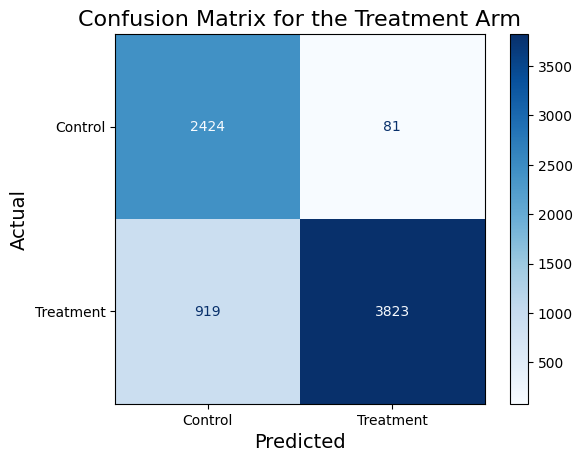

In [ ]:
# call confusion matrix using species test data and the predictions
confusionMatrix = metrics.confusion_matrix(y_test, y_preds)

# bring back the species names
names = ['Control', 'Treatment']
_ = cmplot = metrics.ConfusionMatrixDisplay(confusionMatrix,
                                    display_labels=names)   # we'll display the species names

# changing the color map to blues
_ = cmplot.plot(cmap=plt.get_cmap('Blues'))

# make some titles
_ = plt.title("Confusion Matrix for the Treatment Arm", fontsize=16)
_ = plt.xlabel("Predicted", fontsize=14)
_ = plt.ylabel("Actual", fontsize=14)

_ = plt.show()

This shows decent precision and recall, suggesting a strong correlation between our metrics! But is it between the metrics we predicted? Let's look at our coefficients in our actual regression equation to see what the dominant predictive variables are.

In [ ]:
coefficients = model.coef_
intercept = model.intercept_
equation = "target = {:.2f}".format(intercept[0])
for i, feature in enumerate(X.columns):
    equation += " + {:.2f} * {}".format(coefficients[0][i], feature)

print(equation)

target = -4.49 + -0.75 * population + 14.92 * training_score + -1.15 * dial100 + 0.84 * urban_Urban


In [ ]:
coeffs = {}
for i, feature in enumerate(X.columns):
    coeffs[feature] = coefficients[0][i]
regressionTableUser = pd.DataFrame(coeffs, index=['Coefficent']).T
regressionTableUser.sort_values(by='Coefficent', ascending=False)

,Coefficent
training_score,14.918068
urban_Urban,0.839102
population,-0.750832
dial100,-1.145723


Interesting. It would seem that training_score is the runaway winner in most impactful dependent variable, while dial100 is an order of magnitude weaker in effect. It would seem that we can predict whether or not a station was in the treatment or control arms relatively effectively, but almost exclusively by looking at the randomization data.

### Question 3
**Main Question:**
* How do community perceptions and opinions of police change when different treatments (treatment and WHD variations) are implemented?

**Subquestions:**
* How does the quality of treatment affect it?
Does treatment help user satisfaction and how does that compare to effects on the community?

#### Data

In [ ]:
for key, value in Q3_dic.items():
  print(key)
  try:
    display(value.head())
    value.info()
  except:
    display(value)

folder


'Question_3'

Random_Heterogeninty


,rand_index,total_assigned_officers,total_fir_2017,population,urban,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd
0,0,47,412,129345,Rural,1,-0.234041,Treatment,women officers,1000,9.000000,2.916667,2.200000,0,1
1,1,29,218,170000,Rural,1,-0.960574,Control,control,1000,7.462185,1.545454,1.798067,0,0
2,2,75,694,102467,Rural,1,1.042663,Control,control,1000,7.462185,1.090909,1.798067,0,0
3,3,40,144,54000,Rural,1,-1.590761,Treatment,regular mhd,1000,7.000000,3.897297,2.030000,1,0
4,4,37,130,76376,Rural,1,-1.570695,Treatment,women officers,1000,9.000000,4.157658,2.200000,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rand_index               180 non-null    int64  
 1   total_assigned_officers  180 non-null    int64  
 2   total_fir_2017           180 non-null    int64  
 3   population               180 non-null    int64  
 4   urban                    180 non-null    object 
 5   dist_urban               180 non-null    int64  
 6   strat_pca                180 non-null    float64
 7   treatment                180 non-null    object 
 8   group                    180 non-null    object 
 9   dist_id                  180 non-null    int64  
 10  implement_quality        180 non-null    float64
 11  training_score           180 non-null    float64
 12  comm_outreach_strength   180 non-null    float64
 13  regular_whd              180 non-null    int64  
 14  women_whd                1

,uid,consented,gender,visitsats,comfort,respect,resolution,fclitysats,ps_code,population,...,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd
0,2153QSR,yes,female,Very satisfied,Very comfortable,Very respectfully,Very confident,Very satisfied,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
1,20519SG,yes,female,Somewhat satisfied,Somewhat uncomfortable,Very respectfully,Very confident,Very satisfied,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
2,2051HG7,yes,male,Somewhat satisfied,Very comfortable,Somewhat respectfully,Very confident,Somewhat satisfied,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
3,2051QJF,yes,female,Somewhat satisfied,Somewhat comfortable,Somewhat respectfully,Very confident,Somewhat satisfied,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
4,2051KRN,yes,male,Very satisfied,Somewhat comfortable,Somewhat respectfully,Somewhat confident,Somewhat satisfied,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     3178 non-null   object 
 1   consented               3178 non-null   object 
 2   gender                  3178 non-null   object 
 3   visitsats               3178 non-null   object 
 4   comfort                 3178 non-null   object 
 5   respect                 3178 non-null   object 
 6   resolution              3178 non-null   object 
 7   fclitysats              3178 non-null   object 
 8   ps_code                 3178 non-null   float64
 9   population              3178 non-null   int64  
 10  urban                   3178 non-null   object 
 11  dist_urban              3178 non-null   int64  
 12  strat_pca               3178 non-null   float64
 13  treatment               3178 non-null   object 
 14  group                   3178 non-null   

,uid,b_visit,b_pol_handling,b_safety,e_urja_knowledge,e_visit,e_pol_handling,e_safety,spw,e_gender,...,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd,attrited
0,10512011,0.0,0.444444,3.666667,No,0.0,0.500000,4.0,0.001526,Female,...,-0.004295,Treatment,regular mhd,3000,7.0,3.717949,2.15,1,0,0.0
1,10512031,0.0,-0.111111,2.333333,No,0.0,0.250000,2.0,0.001526,Female,...,-0.004295,Treatment,regular mhd,3000,7.0,3.717949,2.15,1,0,0.0
2,10512041,0.0,-0.200000,3.666667,No,0.0,0.535941,3.0,0.001526,Female,...,-0.004295,Treatment,regular mhd,3000,7.0,3.717949,2.15,1,0,0.0
3,10512141,0.0,0.000000,3.666667,No,0.0,1.000000,3.0,0.001526,Female,...,-0.004295,Treatment,regular mhd,3000,7.0,3.717949,2.15,1,0,0.0
4,10512171,1.0,0.000000,3.333333,No,0.0,0.333333,2.0,0.001526,Female,...,-0.004295,Treatment,regular mhd,3000,7.0,3.717949,2.15,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3294 entries, 0 to 3293
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     3294 non-null   int64  
 1   b_visit                 3294 non-null   float64
 2   b_pol_handling          3294 non-null   float64
 3   b_safety                3294 non-null   float64
 4   e_urja_knowledge        3294 non-null   object 
 5   e_visit                 3294 non-null   float64
 6   e_pol_handling          3294 non-null   float64
 7   e_safety                3294 non-null   float64
 8   spw                     3294 non-null   float64
 9   e_gender                3294 non-null   object 
 10  hh_id                   3294 non-null   float64
 11  member_gender           3294 non-null   object 
 12  ps_code                 3294 non-null   float64
 13  population              3294 non-null   int64  
 14  urban                   3294 non-null   

#### User Survery Logistic Regresson

I am going to use a logsitic regression to predict the resolution score for the user survery. Resolution measures how confident people feel their cases will be delt with by law enforcement. In theory, the more people confident one is, the better the perpetion of the police is. If treatments have a major affect on the resolution, then maybe they really do improve community perception.

In [ ]:
user = Q3_dic['User_Survery']
X = user[['consented', 'gender', 'urban', 'population', 'implement_quality', 'training_score', 'comm_outreach_strength', 'regular_whd',	'women_whd']]

I took a relavent subset of the columns and then had to transform the categorical variables into boolean values for the model to accept them.

In [ ]:
X = pd.get_dummies(X, drop_first=True)

I made the problem binary for simplicity. We are seeing if user if confident in the resolution or not.

In [ ]:
y = user.copy()
y['resolution'] = y['resolution'].apply(lambda x: 1 if x in ['Very confident', 'Somewhat confident'] else 0)
y = y['resolution']

In [ ]:
(y.value_counts().reset_index())

,resolution,count
0,1,2824
1,0,354


Lets build that model. We train test split and then initate a logistic regression that balances the class weights since they are so skewed.
The pipe allows for a one stop shop for scaling and then modelling!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
model = linear_model.LogisticRegression(class_weight='balanced')
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_preds)
f1 = metrics.f1_score(y_test, y_preds)
print(f'Accuracy = {accuracy}, F1 = {f1}')

Accuracy = 0.5754716981132075, F1 = 0.7127659574468085


Ah, solid accuracy and F1, lets look at the confusion matrix to see more.

In [ ]:
# call confusion matrix using species test data and the predictions
confusionMatrix = metrics.confusion_matrix(y_test, y_preds)

# show it
display(confusionMatrix)

array([[ 31,  45],
       [225, 335]])

In [ ]:
225+31

256

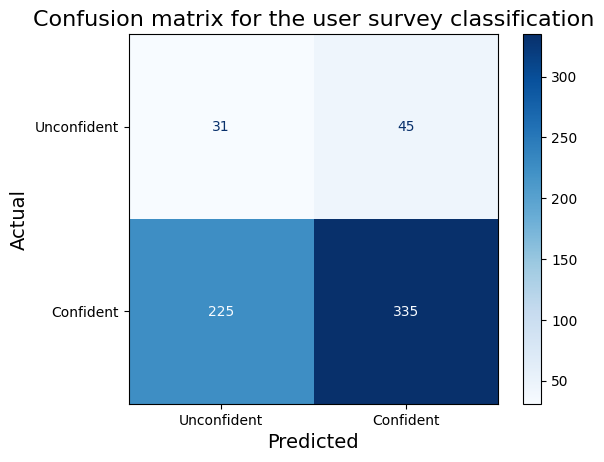

In [ ]:
# bring back the species names
names = ['Unconfident', 'Confident']
_ = cmplot = metrics.ConfusionMatrixDisplay(confusionMatrix,
                                    display_labels=names)   # we'll display the species names

# changing the color map to blues
_ = cmplot.plot(cmap=plt.get_cmap('Blues'))

# make some titles
_ = plt.title("Confusion matrix for the user survey classification", fontsize=16)
_ = plt.xlabel("Predicted", fontsize=14)
_ = plt.ylabel("Actual", fontsize=14)
_ = plt.savefig('/content/drive/MyDrive/Data - Human Centered DS/Plots/cfmatriclogisticq3.png', bbox_inches='tight', dpi=400)
_ = plt.show()

So the acccuracy is misleading. It cannot consistently predict based on the data. It jsut assumes it is mostly going to be confident which makes the f1 score deceptive. It only is doing a bit better than what one would expect if they guessed for every single one. Maybe the regression equation could illuminate what is going on here.

In [ ]:
coefficients = model.coef_
intercept = model.intercept_
equation = "target = {:.2f}".format(intercept[0])
for i, feature in enumerate(X.columns):
    equation += " + {:.2f} * {}".format(coefficients[0][i], feature)

print(equation)

target = -0.01 + 0.31 * population + -0.05 * implement_quality + -0.17 * training_score + -0.00 * comm_outreach_strength + 0.66 * regular_whd + 0.32 * women_whd + -0.06 * gender_male + -0.46 * urban_Urban


In [ ]:
coeffs = {}
for i, feature in enumerate(X.columns):
    coeffs[feature] = coefficients[0][i]
regressionTableUser = pd.DataFrame(coeffs, index=['Coefficent']).T
regressionTableUser.sort_values(by='Coefficent', ascending=False)

,Coefficent
regular_whd,0.663981
women_whd,0.319763
population,0.309491
comm_outreach_strength,-0.004438
implement_quality,-0.053362
gender_male,-0.056390
training_score,-0.165103
urban_Urban,-0.456135


Women help desks (both regular and woman run) seem to be the big factors when it come to haveing positive relationship with a positive resolution. But then training score and implement quality are two of the bottom Five with a negative relationhip with a positive resolution. The best response to this model is that these relationships are not strong. That indicates that the answer to our question is that there are no true relationships between the treatment factors and community perception. Perceptions do not change so linearly, they take time and it is not the simple for any one.

### Question 4
**Main Question:**
* How much does the number of female officers/presence of a female helpdesk affect the number of women that enter the station?

**Subquestions:**
* Will more women enter the station if they know there are women there to help them?
* Does this have an effect on the number of reports filed (FIR and DIR)?
* Does urban versus rural areas make a difference in this regard?


#### Data

In [ ]:
for key, value in Q4_dic.items():
  print(key)
  try:
    display(value.head())
    value.info()
  except:
    display(value)

folder


'Question_4'

Admin


,month,fir_overall_count,fir_caw_count,fir_bywomen_count,arrest_count,dir_count,ncr_count,dial100_count,ps_code,population,...,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd
0,2019-06-01,35,8,5,20,0,100,40.0,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
1,2019-11-01,29,10,4,10,1,0,35.0,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
2,2018-10-01,26,8,3,12,0,72,25.0,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
3,2018-11-01,27,8,4,12,0,64,41.0,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1
4,2020-05-01,32,6,4,10,0,22,55.0,1001.0,129345,...,1,-0.234041,Treatment,women officers,1000,9.0,2.916667,2.2,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   4500 non-null   object 
 1   fir_overall_count       4500 non-null   int64  
 2   fir_caw_count           4500 non-null   int64  
 3   fir_bywomen_count       4500 non-null   int64  
 4   arrest_count            4500 non-null   int64  
 5   dir_count               4500 non-null   int64  
 6   ncr_count               4500 non-null   int64  
 7   dial100_count           4500 non-null   float64
 8   ps_code                 4500 non-null   float64
 9   population              4500 non-null   int64  
 10  urban                   4500 non-null   object 
 11  dist_urban              4500 non-null   int64  
 12  strat_pca               4500 non-null   float64
 13  treatment               4500 non-null   object 
 14  group                   4500 non-null   

,Unnamed: 0,ps_code,urban,dist_urban,strat_pca,treatment,group,dist_id,training_score,regular_whd,...,b_total_surveyed,b_female_surveyed,b_male_surveyed,population,implement_quality,comm_outreach_strength,e_male_weight,b_male_weight,e_female_weight,b_female_weight
0,0,1001.0,Rural,1,-0.234041,Treatment,women officers,1000,2.916667,0,...,10,0,10,129345,9,2.200000,3.818182,3.272727,6.000000,3.000000
1,1,1002.0,Rural,1,-0.960574,Control,control,1000,1.545454,0,...,11,0,11,170000,7,1.798067,2.454546,1.727273,0.000000,1.000000
2,2,1003.0,Rural,1,1.042663,Control,control,1000,1.090909,0,...,11,2,9,102467,7,1.798067,7.300000,4.900000,3.000000,3.500000
3,3,1004.0,Rural,1,-1.590761,Treatment,regular mhd,1000,3.897297,1,...,13,3,10,54000,7,2.030000,3.000000,1.800000,1.000000,1.333333
4,4,1005.0,Rural,1,-1.570695,Treatment,women officers,1000,4.157658,0,...,12,2,10,76376,9,2.200000,2.777778,2.500000,2.333333,1.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              3416 non-null   int64  
 1   ps_code                 3416 non-null   float64
 2   urban                   3416 non-null   object 
 3   dist_urban              3416 non-null   int64  
 4   strat_pca               3416 non-null   float64
 5   treatment               3416 non-null   object 
 6   group                   3416 non-null   object 
 7   dist_id                 3416 non-null   int64  
 8   training_score          3416 non-null   float64
 9   regular_whd             3416 non-null   int64  
 10  women_whd               3416 non-null   int64  
 11  dayofweek               3416 non-null   object 
 12  timeofday               3416 non-null   object 
 13  eavg_all                3416 non-null   float64
 14  eavg_women              3416 non-null   

,rand_index,total_assigned_officers,total_fir_2017,population,urban,dist_urban,strat_pca,treatment,group,dist_id,implement_quality,training_score,comm_outreach_strength,regular_whd,women_whd
0,0,47,412,129345,Rural,1,-0.234041,Treatment,women officers,1000,9.000000,2.916667,2.200000,0,1
1,1,29,218,170000,Rural,1,-0.960574,Control,control,1000,7.462185,1.545454,1.798067,0,0
2,2,75,694,102467,Rural,1,1.042663,Control,control,1000,7.462185,1.090909,1.798067,0,0
3,3,40,144,54000,Rural,1,-1.590761,Treatment,regular mhd,1000,7.000000,3.897297,2.030000,1,0
4,4,37,130,76376,Rural,1,-1.570695,Treatment,women officers,1000,9.000000,4.157658,2.200000,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rand_index               180 non-null    int64  
 1   total_assigned_officers  180 non-null    int64  
 2   total_fir_2017           180 non-null    int64  
 3   population               180 non-null    int64  
 4   urban                    180 non-null    object 
 5   dist_urban               180 non-null    int64  
 6   strat_pca                180 non-null    float64
 7   treatment                180 non-null    object 
 8   group                    180 non-null    object 
 9   dist_id                  180 non-null    int64  
 10  implement_quality        180 non-null    float64
 11  training_score           180 non-null    float64
 12  comm_outreach_strength   180 non-null    float64
 13  regular_whd              180 non-null    int64  
 14  women_whd                1

#### CCTV

I am going to try to predict the end average of women that walk into a given station. The more women walking into the station from endline may indicate that the treatments worked and made people more confident in the police force.

In [ ]:
CCTV = Q4_dic['CCTVwFemaleStaff']
CCTV = noOutliers(CCTV, 'eavg_women')
X = CCTV[['dayofweek', 'timeofday', 'e_male_officers', 'e_female_officers',
          'regular_whd', 'women_whd', 'population', 'training_score', 'implement_quality', 'comm_outreach_strength']]
y = CCTV['eavg_women']

In [ ]:
y.describe()

,eavg_women
count,3061.000000
mean,11.012590
std,6.113739
min,0.000000
25%,5.500000
50%,14.080100
75%,14.689332
max,27.491407


In [ ]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
model = linear_model.LinearRegression()
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train) #fit_transforms for standardization before fitting model
y_preds = pipe.predict(X_test)

In [ ]:
r2 = metrics.r2_score(y_test, y_preds)
rmse = rms_error(y_test, y_preds)

print(f'R-squared = {r2}, RMSE = {rmse}')

R-squared = 0.15008920704745332, RMSE = 5.589298348397945


Wow, that is really bad! These variables seem to have little to no predictive power.

In [ ]:
coefficients = model.coef_
intercept = model.intercept_
equation = "target = {:.2f}".format(intercept)
for i, feature in enumerate(X.columns):
    equation += " + {:.2f} * {}".format(coefficients[i], feature)

print(equation)

target = 9.05 + 10.03 * e_male_officers + -0.01 * e_female_officers + -1.04 * regular_whd + -0.95 * women_whd + 0.45 * population + 1.32 * training_score + -3.03 * implement_quality + 1.63 * comm_outreach_strength + 0.26 * dayofweek_Mon + -0.40 * dayofweek_Sat + -0.43 * dayofweek_Sun + 0.21 * dayofweek_Thu + 0.16 * dayofweek_Tue + 0.52 * dayofweek_Wed + -0.21 * timeofday_evening + -0.05 * timeofday_morning


In [ ]:
coeffs = {}
for i, feature in enumerate(X.columns):
    coeffs[feature] = coefficients[i]
regressionTableUser = pd.DataFrame(coeffs, index=['Coefficent']).T
regressionTableUser.sort_values(by='Coefficent', ascending=False)

,Coefficent
e_male_officers,10.032255
comm_outreach_strength,1.633588
training_score,1.316577
dayofweek_Wed,0.519978
population,0.449483
dayofweek_Mon,0.258056
dayofweek_Thu,0.206028
dayofweek_Tue,0.163151
e_female_officers,-0.005392
timeofday_morning,-0.052395


Okay, another bad model, the strongest indicator is total officers. So the amount of people going into the station has more to do with the amount of people in the station, not how many women there are. That seem intutively possible! The more staff allows for more help and there are probably more people in areas with more officers (or just more need). But then female officer is the most negative relationship, which indicates that the number of women does not actually cause people to come in, (and may even deter people from going in (but that seems more coincidential)). Maybe the overarching department puts women in lower risk areas with less traffic... (but there is no evidence of that here). The best thing I can say is there is no real relationship between the foot traffic and female officers or whds.

 - NOTE: I ran this model without total officers and it's R2 was down to 0.18, which indicates that you are alost as good as guessing than using this model. The number of total officers has some significant perdictive power and should be in the model.

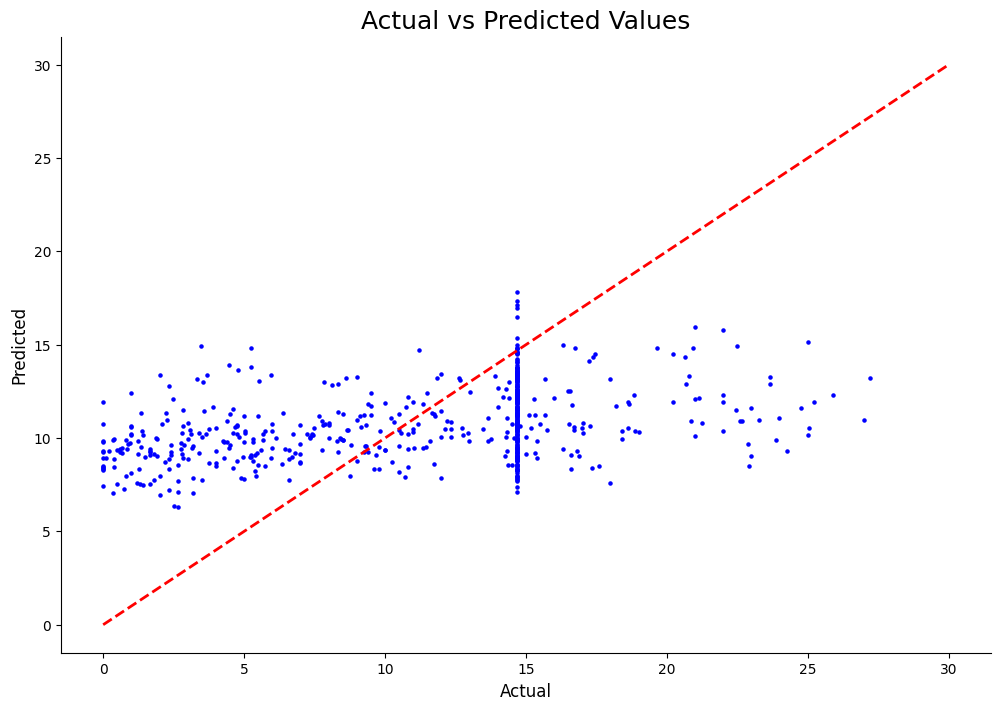

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_preds, color='blue', s=5)
plt.plot([y_test.min(), 30], [y_test.min(), 30], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.title('Actual vs Predicted Values', fontsize=18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('/content/drive/MyDrive/Data - Human Centered DS/Plots/CCTVregression.png', bbox_inches='tight', dpi=400)
plt.show()

Such an abysmal relationship.

#### Admin

In [ ]:
admin = Q4_dic['Admin']
admin = noOutliers(admin, 'fir_overall_count')

I plan to use a linear regression to predict the number of overall fir based on factors like woman help desks and treatments (amoung other things). Linear regression seems like a solid problem to solve since the number of firs is a strong indicator of how police are responding to CAW. I take out strat_pca since it sucks the variance out of the variables (and that is what I want to see).

In [ ]:
admin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4352 entries, 0 to 4499
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   4352 non-null   object 
 1   fir_overall_count       4352 non-null   int64  
 2   fir_caw_count           4352 non-null   int64  
 3   fir_bywomen_count       4352 non-null   int64  
 4   arrest_count            4352 non-null   int64  
 5   dir_count               4352 non-null   int64  
 6   ncr_count               4352 non-null   int64  
 7   dial100_count           4352 non-null   float64
 8   ps_code                 4352 non-null   float64
 9   population              4352 non-null   int64  
 10  urban                   4352 non-null   object 
 11  dist_urban              4352 non-null   int64  
 12  strat_pca               4352 non-null   float64
 13  treatment               4352 non-null   object 
 14  group                   4352 non-null   objec

In [ ]:
X = admin.drop(columns= ['fir_overall_count','month', 'fir_caw_count',	'fir_bywomen_count', 'strat_pca',
                         'arrest_count',	'dir_count',	'ncr_count', 'ps_code', 'dist_id'])
y = admin['fir_overall_count']
X = pd.get_dummies(X, columns=['urban', 'treatment', 'group'], drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

model = linear_model.LinearRegression()
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

mse, r2

(175.47346061406643, 0.39368139014556514)

Ouch, still a fairly dissapointing model (even though it is better than the average of the CV)! It seems our questions are a bit far fetched. Lets look closer at the model itself.

In [ ]:
coefficients = model.coef_
intercept = model.intercept_
equation = "target = {:.2f}".format(intercept)
for i, feature in enumerate(X.columns):
    equation += " + {:.2f} * {}".format(coefficients[i], feature)

print(equation)

target = 18.50 + 94.13 * dial100_count + 5.79 * population + -1.25 * dist_urban + 3.36 * implement_quality + -9.24 * training_score + -0.71 * comm_outreach_strength + -91910072104398.58 * regular_whd + -46580907970733.39 * women_whd + 9.06 * urban_Urban + 94475088766623.58 * treatment_Treatment + -2565016662224.28 * group_regular mhd + -47894180795888.32 * group_women officers


In [ ]:
coeffs = {}
for i, feature in enumerate(X.columns):
    coeffs[feature] = coefficients[i]
regressionTableUser = pd.DataFrame(coeffs, index=['Coefficent']).T
pd.options.display.float_format = '{:,.2f}'.format
regressionTableUser.sort_values(by='Coefficent', ascending=False)

,Coefficent
treatment_Treatment,"94,475,088,766,623.58"
dial100_count,94.13
urban_Urban,9.06
population,5.79
implement_quality,3.36
comm_outreach_strength,-0.71
dist_urban,-1.25
training_score,-9.24
group_regular mhd,"-2,565,016,662,224.28"
women_whd,"-46,580,907,970,733.39"


My knee jerk reaction to this model is that it simply fails. Obviously the model is not accurate, so it simply indicates that the relationships are weak (and this aligns with correlation matrices looked at  during EDA). Also, even though the main indicators are represented in the model's main varinaces (they are obnoxiously large), they seem to cancel eachother out, which does not help us. Taking all but one of them out of the model also throws it off entirely since all the variance is missing from the mdoe. Basically, there is no rhyme of reason to the number of firs overall. The data does not say a clear message since the model scores less than 0.6 $R^2$.

<ipython-input-62-261153700db6>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Diagonal line


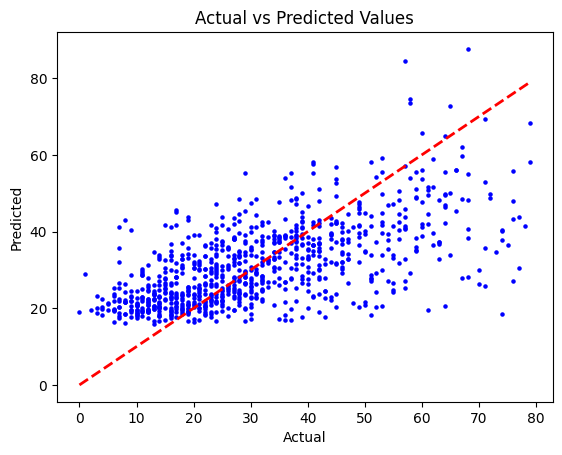

In [ ]:
plt.scatter(y_test, y_pred, color='blue', s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

Looks linear in one way, so maybe the main variables do have the most impact on the number of firs, but in what way it known little. Still unsure whether these indicators really say much about the the number of firs, but maybe some EDA and visualizations can support that these indicators are truly there.